In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import time
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML

%tensorflow_version 2.x
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dropout

TensorFlow 2.x selected.


# Utility functions

In [0]:
def normalize_value(val, max_val, min_val):
    '''
        The returns the normalized version of an value, given
        the maximum value and minimum value in the data_column

        Using formula:

        Norm value = (x_i - (a+b)/2) / ((a-b)/2)
    '''
    return (val - (max_val + min_val)/2) / ((max_val - min_val)/2)

def normalize_data(X_train, X_test):
    '''
        Normalizes the dataset to (-1, to 1); and uses ranges from the training
        data, to normalize the testing data.
    '''

    X_train_normalized = X_train[:, 0] # the first columns are just ones for constants
    X_test_normalized = X_test[:, 0]

    for i in range(1, X_train.shape[1]):
        max_val = np.max(X_train[:, i])
        min_val = np.min(X_train[:, i])

        col_normalized_train = [normalize_value(val, max_val, min_val) for val in X_train[:, i]] 
        col_normalized_test = [normalize_value(val, max_val, min_val) for val in X_test[:, i]]

        X_train_normalized = np.column_stack((X_train_normalized, col_normalized_train))
        X_test_normalized = np.column_stack((X_test_normalized, col_normalized_test))

    return X_train_normalized, X_test_normalized

def calc_msfe(y_actual, y_predictions):
    '''
        Calculates Mean Squared Forecast Error (MSFE) between the predicted and
        actual value.
    '''
    n = len(y_actual)
    errors = [(y_actual[i]-y_predictions[i])**2 for i in range(n)]
    return np.sum(errors)/n

def calc_historical_average_return_forecast(returns, num_out_sample):   
    '''
        Computes the historical average return forecast.
        The forecast is estimated as the average return of all the past time periods, as
        defined in teh equation above.
    '''
    forecasted_returns = [(np.sum(returns[:t])/t) for t in range(1, len(returns))]
    return forecasted_returns[((-1)*num_out_sample):]

def calc_r2_os(y_actual, y_predictions, benchmark_predictions):
    '''
        Computes the R2_os score for each model by comparing it with the MSFE of
        historical average return forecast
    '''
    msfe_i = calc_msfe(y_actual, y_predictions)
    msfe_0 = calc_msfe(y_actual, benchmark_predictions)
    return 1 - (msfe_i / msfe_0)

def calc_R2OS_and_p_value(e_HA, FC_HA, e_X, FC_X):


    # R2OS
    R2OS = 100*(1- (np.sum(np.power(e_X, 2)) / np.sum(np.power(e_HA, 2))))
    
    # P-value
    e_X_reshaped = e_X.reshape(e_X.shape[0], 1)
    FC_X_reshaped = FC_X.reshape(FC_X.shape[0], 1)
    f_i = np.power(e_HA, 2) - (np.power(e_X_reshaped,2) - np.power(FC_HA - FC_X_reshaped, 2))

    results_i  = sm.OLS(f_i, np.ones((f_i.shape[0], 1))).fit()
    results_i = results_i.get_robustcov_results(cov_type='HAC',maxlags=0)
    p_value = 1 - norm.cdf(results_i.tvalues[0], loc=0, scale=1)

    return R2OS, p_value


# Rapach et. al. (2013) replication

In [0]:
def rapach_forecasts(Y, X, X_sink,
                        predictors, 
                        n_in_sample,
                        n_holdout_sample,
                        n_forecast_evaluation, idx_svar, theta=0.75):
    
    '''
        Estimates forecasts using replicated model from Rapach. et. al (2013)
    '''

    # Estimating full parameters for Cambell Thompson restrictions
    BETA_FULL = np.zeros((X.shape[1], 1))
    T = Y.shape[0]

    for i in range(X.shape[1]):
        rhs_i = np.column_stack((X[: T-1, i], np.ones(T-1)))
        model = sm.OLS(Y[1:T], rhs_i)
        results_i = model.fit()
        BETA_FULL[i] = results_i.params[0]

    if BETA_FULL[idx_svar] < 0:
        BETA_FULL[idx_svar] = 1

    print(BETA_FULL)

    n_predictors = X.shape[1]

    # Computing forecasts !
    FC_HA = np.zeros((n_holdout_sample+n_forecast_evaluation, 1)) # Forecast for average benchmark model
    FC_ECON = np.zeros((n_holdout_sample+n_forecast_evaluation, n_predictors)) #Forecast with economic variable
    beta_ECON = np.zeros((n_holdout_sample+n_forecast_evaluation, n_predictors, 2)) # beta coefficient for economic variable
    FC_ECON_CT = np.zeros((n_holdout_sample+n_forecast_evaluation, n_predictors))
    omega_DMSFE =  np.zeros((n_holdout_sample+n_forecast_evaluation, n_predictors))
    FC_OTHER = np.zeros((n_holdout_sample+n_forecast_evaluation, 3))
    FC_OTHER_CT = np.zeros((n_holdout_sample+n_forecast_evaluation, 3))

    for t in range(n_holdout_sample + n_forecast_evaluation):
        FC_HA[t] = np.mean(Y[: (n_in_sample + (t))])
        X_t = X[:n_in_sample + (t) - 1 , :] 
        Y_t = Y[1:(n_in_sample + (t))]

        for i in range(n_predictors):
            model = sm.OLS(Y_t, np.column_stack((X_t[:, i], np.ones(len(X_t[:, i])))))
            results_t_i = model.fit()
            FC_ECON[t, i] = np.dot(np.array([X[n_in_sample + (t-1), i], 1.0]),results_t_i.params)

            # beta => coefficient
            beta_ECON[t, i, 0] = results_t_i.params[0]
            # bse => standard error
            beta_ECON[t, i, 1] = results_t_i.bse[0]

            # CT restrictions
            if BETA_FULL[i] > 0:
                if results_t_i.params[0] > 0:
                    FC_ECON_CT[t, i] = FC_ECON[t, i]
                # elif result_t_i.params[0] < 0:
                else:
                    # if the coefficient of regression is negative
                    # assuming same value as the historical average
                    FC_ECON_CT[t, i] = FC_HA[t]
            elif BETA_FULL[i] < 0:
                if results_t_i.params[0] < 0:
                    FC_ECON_CT[t, i] = FC_ECON[t, i]
                else:
                # elif results_t_i.params[0] > 0:
                    FC_ECON_CT[t, i] = FC_HA[t]
            
            # Finaally if the forecat is negative setting it to zero
            if FC_ECON_CT[t, i] < 0:
                FC_ECON_CT[t, i] = 0

        #######
        ## Combined Forecasts
        #######
        if t >= n_holdout_sample:
            
            #######
            # Kitchen sink forecast
            #######
            X_t_sink = X_sink[:n_in_sample + (t-1), :]
            model = sm.OLS(Y_t, np.column_stack((X_t_sink, np.ones(len(X_t_sink)))))
            results_t_sink = model.fit()
            FC_OTHER[t, 0] = np.dot(np.append(X_sink[n_in_sample + (t-1), :], 1.0), results_t_sink.params)

            # Campbell Thompson restrictions
            if FC_OTHER[t, 0] < 0:
                FC_OTHER_CT[t, 0] = 0
            else:
                FC_OTHER_CT[t, 0] = FC_OTHER[t, 0]
            
            
            #######
            # Pooled forecast: simple average
            #######
            FC_OTHER[t, 1] = np.mean(FC_ECON[t, :])
            
            # if value is negative, we change it to zero.
            if FC_OTHER[t, 1] < 0:
                FC_OTHER_CT[t, 1] = 0
            else:
                FC_OTHER_CT[t, 1] = FC_OTHER[t, 1]

            #######
            ## Pooled forecast: DMSFE
            #######
            powers_t = np.array(range(t-1, -1, -1))
            # 1st part of equation: sum(((kron(ones(1,N),(theta*ones(t-1,1)).^powers_t)).^powers_t)) 
            thetas_powered = np.power(theta * np.ones(t), powers_t)
            kron_1 = np.kron(np.ones((1, n_predictors)), thetas_powered.reshape(-1, 1))

            # 2nd part of equation: ((kron(ones(1,N),Y(R+1:R+(t-1)))-FC_ECON(1:(t-1),:)).^2)
            kron_2 = np.kron(np.ones((1, n_predictors)), Y[n_in_sample:(n_in_sample + t)].reshape(-1, 1))
            kron_2_diff = kron_2 - FC_ECON[:t, :]
            kron_2_diff_squared = np.power(kron_2_diff, 2)

            kron_product = np.multiply(kron_1, kron_2_diff_squared)
            m = np.sum(kron_product, axis=0)
            omega = np.power(m, -1) / np.sum(np.power(m, -1))
            omega_DMSFE[t, :] = omega

            FC_OTHER[t, 2] = np.dot(FC_ECON[t, :], omega)
            if FC_OTHER[t, 2] < 0:
                FC_OTHER_CT[t, 2] = 0
            else:
                FC_OTHER_CT[t, 2] = FC_OTHER[t, 2]


    ## Setting up forecasts by removing forecasts for holdout sample
    beta_ECON = beta_ECON[n_holdout_sample:, :, :]
    actual = np.reshape(Y[n_in_sample + n_holdout_sample :], (Y[n_in_sample + n_holdout_sample:].shape[0], 1))
    FC_HA = FC_HA[n_holdout_sample:]
    FC_ECON = FC_ECON[n_holdout_sample:, :]
    FC_ECON_CT = FC_ECON_CT[n_holdout_sample:, :]
    FC_OTHER = FC_OTHER[n_holdout_sample:, :];
    FC_OTHER_CT = FC_OTHER_CT[n_holdout_sample:, :]
    omega_DMSFE = omega_DMSFE[n_holdout_sample:, :]


    ######
    ## R2OS score calculation for Individual predictors
    ######
    e_HA = actual - FC_HA
    e_ECON = np.kron(np.ones((1, FC_ECON.shape[1])), actual) - FC_ECON
    e_ECON_CT = np.kron(np.ones((1, FC_ECON_CT.shape[1])), actual) - FC_ECON_CT
    CSFE_HA = np.cumsum(np.power(e_HA, 2), axis=0)
    CSFE_ECON = np.cumsum(np.power(e_ECON, 2), axis=0)
    CSFE_ECON_CT = np.cumsum(np.power(e_ECON_CT, 2), axis=0)
    DCSFE_ECON = np.kron(np.ones((1, FC_ECON.shape[1])), CSFE_HA) - CSFE_ECON
    DCSFE_ECON_CT = np.kron(np.ones((1, FC_ECON_CT.shape[1])), CSFE_HA) - CSFE_ECON_CT
    R2OS_ECON=np.zeros((FC_ECON.shape[1],2));
    R2OS_ECON_CT=np.zeros((FC_ECON_CT.shape[1], 2));

    for i in range(R2OS_ECON.shape[0]):
        R2OS_ECON[i, 0], R2OS_ECON[i, 1] = calc_R2OS_and_p_value(e_HA, FC_HA, e_ECON[:, i], FC_ECON[:, i])
        R2OS_ECON_CT[i, 0], R2OS_ECON_CT[i, 1] = calc_R2OS_and_p_value(e_HA, FC_HA, e_ECON_CT[:, i], FC_ECON_CT[:, i])

    ######
    ## R2OS score calculation for Combined predictors
    ######
    e_OTHER = np.kron(np.ones((1, FC_OTHER.shape[1])), actual) - FC_OTHER
    e_OTHER_CT = np.kron(np.ones((1, FC_OTHER_CT.shape[1])), actual) - FC_OTHER_CT
    CSFE_HA = np.cumsum(np.power(e_HA, 2), axis=0)
    CSFE_OTHER = np.cumsum(np.power(e_OTHER, 2), axis=0)
    CSFE_OTHER_CT = np.cumsum(np.power(e_OTHER_CT, 2), axis=0)
    DCSFE_OTHER = np.kron(np.ones((1, FC_OTHER.shape[1])), CSFE_HA) - CSFE_OTHER
    DCSFE_OTHER_CT = np.kron(np.ones((1, FC_OTHER_CT.shape[1])), CSFE_HA) - CSFE_OTHER_CT
    R2OS_OTHER=np.zeros((FC_OTHER.shape[1],2));
    R2OS_OTHER_CT=np.zeros((FC_OTHER_CT.shape[1], 2));

    for i in range(R2OS_OTHER.shape[0]):
        R2OS_OTHER[i, 0], R2OS_OTHER[i, 1] = calc_R2OS_and_p_value(e_HA, FC_HA, e_OTHER[:, i], FC_OTHER[:, i])
        R2OS_OTHER_CT[i, 0], R2OS_OTHER_CT[i, 1] = calc_R2OS_and_p_value(e_HA,  FC_HA, e_OTHER_CT[:, i], FC_OTHER_CT[:, i])



    #####
    # Generating results
    ####
    predictors_combined = ['Kitchen sink', 'POOL-AVG', 'POOL-DMSFE']


    df_unrestricted = pd.DataFrame({
        'predictors': predictors + predictors_combined,
        'R2OS': np.append(R2OS_ECON[:, 0], R2OS_OTHER[:, 0]),
        'p-value': np.append(R2OS_ECON[:, 1], R2OS_OTHER[:, 1]),
    })

    df_restricted = pd.DataFrame({
        'predictors': predictors + predictors_combined,
        'R2OS': np.append(R2OS_ECON_CT[:, 0], R2OS_OTHER_CT[:, 0]),
        'p-value': np.append(R2OS_ECON_CT[:, 1], R2OS_OTHER_CT[:, 1]),
    })

    forecasts = {
        'econ_unrestricted': FC_ECON,
        'econ_restricted': FC_ECON_CT,
        'combined_unrestricted': FC_OTHER,
        'combined_restricted': FC_OTHER_CT,
        'actual': actual,
        'ha': FC_HA
    }
    
    return {
        'results_unrestricted': df_unrestricted,
        'results_restricted': df_restricted,
        'forecasts': forecasts
    }

# Forecasts for NYSE (1956 - 2010)

In [0]:
# Loading and preparing data
url_data = 'https://github.com/nik1997/capstone2020/blob/master/data/Returns_handbook_data.xls?raw=true'
data = pd.read_excel(url_data, 'Monthly')
data.head()

# Equity premium

idx_first = 671 # starting data 1926:11
idx_last = 1679 # final date 2010:12

timestamps = data.loc[idx_first:idx_last, 'Date (yyyymm)']

market_return = np.array(data.loc[idx_first:idx_last, ['CRSP S&P 500 value-weighted return with dividends']]).flatten()
r_f_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'Risk-free rate']) # risk free rate
equity_premium = np.log(1+market_return)-np.log(1+r_f_lag) # log excess return


#dividends
d12=np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 dividends']) 
#S7P 500 index
sp500 = np.array(data.loc[idx_first:idx_last, 'S&P 500 index']) 
# log dividend-price ratio
dp = np.log(d12) - np.log(sp500) 
# S&P 500 index, lagged 
sp500_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'S&P 500 index']) # S&P 500 index, lagged 
# log dividend yield
dy = np.log(d12) - np.log(sp500_lag)
# earnings
e12 = np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 earnings'])
# log earnings to price ratio
ep = np.log(e12) - np.log(sp500)
# log dividend-payout ratio
de = np.log(d12) - np.log(e12)
# volatility (SVAR)
svar = np.array(data.loc[idx_first:idx_last, 'Monthly sum of squared daily returns on S&P 500 index'])
# book to market ratio
bm = np.array(data.loc[idx_first:idx_last, 'DJIA book-to-market value ratio'])
# net equity issuing activity
ntis=np.array(data.loc[idx_first:idx_last, 'Net equity expansion'])
# t-bill raate
tbl = np.array(data.loc[idx_first:idx_last, '3-month Treasury bill yield (secondary market)'])
# long-term government bond yield
lty = np.array(data.loc[idx_first:idx_last, 'Long-term government bond yield'])
# long-term governmnent bond return
ltr = np.array(data.loc[idx_first:idx_last, 'Long-term government bond return'])
# term spread
tms=lty-tbl
# AAA-rated corporate bond yield
aaa = np.array(data.loc[idx_first:idx_last, 'Moodys AAA-rated corporate bond yield'])
# BAA-rated corporate bond yield
baa = np.array(data.loc[idx_first:idx_last, 'Moodys BAA-rated corporate bond yield'])
# Default yield spread
dfy = baa-aaa
# Long-term corporate bond return
corpr = np.array(data.loc[idx_first:idx_last, 'Long-term corporate bond return'])
# Default return spread
dfr = corpr - ltr
# Inflation, lagged(1926:11-2010:11)
infl_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'CPI (all urban consumers) inflation rate'])
# Combined arrays of all variable
                     
econ = np.column_stack((dp, dy, ep, de, svar, bm, ntis, tbl, lty, ltr, tms, dfy, dfr, infl_lag))
econ_sink = np.column_stack((dp, dy, ep, svar, bm, ntis, tbl, lty, ltr, dfy, dfr, infl_lag))

In [0]:
predictors = ['dp', 'dy', 'ep', 'de', 'svar', 'bmr', 'ntis', 'tbl', 'lty', 'ltr', 'tms', 'dfy', 'dfr', 'infl_lag']


# Preparing data
Y = equity_premium[:]
T = Y.shape[0]

n_in_sample = (1946-1926)*12+1
n_holdout_sample = (1956-1946)*12
n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) # Forecast evaluation peroid


def change_number_to_date(timestamp):
    timestamp = str(timestamp)
    year = timestamp[:4]
    month = timestamp[4:6]
    str_timestamp = '{}-{}-01'.format(year, month)
    return str_timestamp

timestamps = timestamps.apply(change_number_to_date)
timestamps = pd.to_datetime(timestamps)
timestamps = timestamps[n_in_sample + n_holdout_sample:]
timestamps = timestamps.reset_index()
timestamps = timestamps['Date (yyyymm)']

# parameters
Y = Y
X = econ
X_sink = econ_sink
idx_svar = 4
theta=0.75


rapach_results = rapach_forecasts(Y, econ, econ_sink,
                predictors, 
                n_in_sample,
                n_holdout_sample,
                n_forecast_evaluation, idx_svar, theta)


print('\nR2OS for Unrestricted')
print('---'*20)
display(rapach_results['results_unrestricted'].round(2))

print('\nR2OS with restricted')
print('---'*20)
display(rapach_results['results_restricted'].round(2))

[[ 0.00647033]
 [ 0.00781829]
 [ 0.00864035]
 [-0.00233856]
 [ 1.        ]
 [ 0.01514282]
 [-0.13465435]
 [-0.07879868]
 [-0.05998025]
 [ 0.1030293 ]
 [ 0.15664405]
 [ 0.09652975]
 [ 0.17803721]
 [-0.19076655]]

R2OS for Unrestricted
------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,predictors,R2OS,p-value
0,dp,-0.05,0.10
1,dy,-0.37,0.07
2,ep,-1.88,0.28
3,de,-2.04,0.97
4,svar,0.32,0.17
5,bmr,-1.74,0.31
6,ntis,-0.91,0.41
7,tbl,-0.01,0.09
8,lty,-1.17,0.12
9,ltr,-0.08,0.20



R2OS with restricted
------------------------------------------------------------


,predictors,R2OS,p-value
0,dp,0.15,0.07
1,dy,0.17,0.04
2,ep,-0.82,0.24
3,de,-1.74,0.98
4,svar,0.00,NaN
5,bmr,-1.17,0.29
6,ntis,-0.91,0.41
7,tbl,0.21,0.10
8,lty,-0.01,0.09
9,ltr,0.22,0.12


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


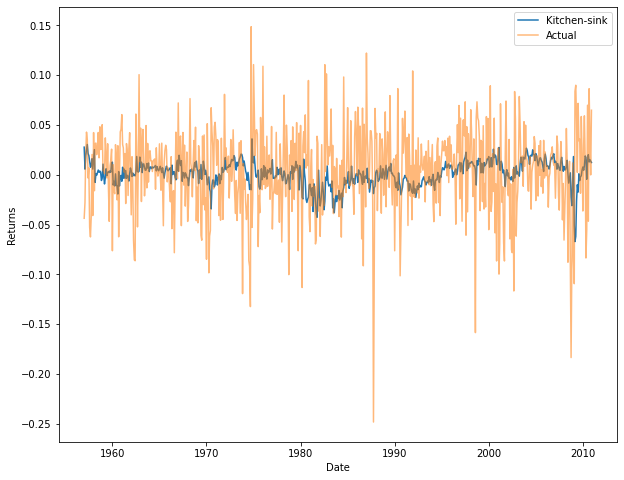

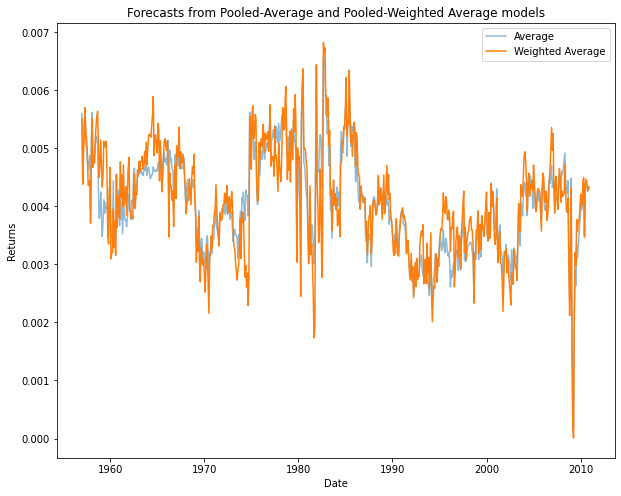

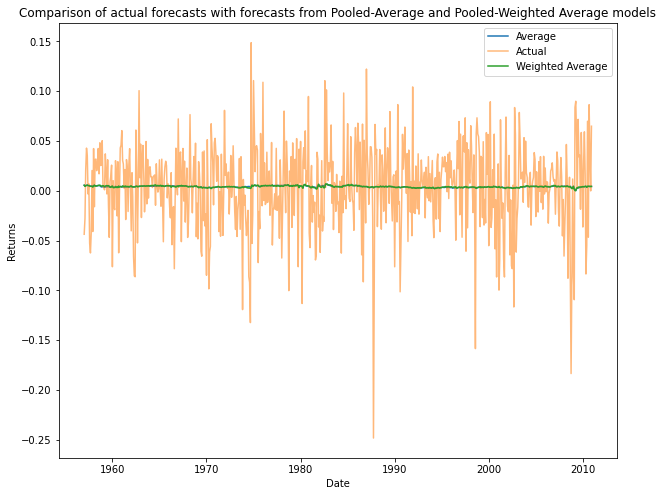

In [0]:
# Plots for comparing the forecasts of different models with actual data
plt.figure(figsize=(10, 8))
plt.plot(timestamps, rapach_results['forecasts']['combined_unrestricted'][:,0], label='Kitchen-sink')
plt.plot(timestamps, rapach_results['forecasts']['actual'], label='Actual', alpha=0.55)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(timestamps, rapach_results['forecasts']['combined_unrestricted'][:,1], label='Average', alpha=0.5)
plt.plot(timestamps, rapach_results['forecasts']['combined_unrestricted'][:,2], label='Weighted Average')
plt.title('Forecasts from Pooled-Average and Pooled-Weighted Average models')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(timestamps, rapach_results['forecasts']['combined_unrestricted'][:,1], label='Average')
plt.plot(timestamps, rapach_results['forecasts']['actual'], label='Actual', alpha=0.55)
plt.plot(timestamps, rapach_results['forecasts']['combined_unrestricted'][:,2], label='Weighted Average')
plt.title('Comparison of actual forecasts with forecasts from Pooled-Average and Pooled-Weighted Average models')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

In [0]:
# Estimating MSFE of the mdoels
y_actual = rapach_results['forecasts']['actual'].flatten()

print('MSFE Kitchen Sink:',calc_msfe(y_actual, rapach_results['forecasts']['combined_unrestricted'][:,0]))
print('MSFE Pooled-Average:',calc_msfe(y_actual, rapach_results['forecasts']['combined_unrestricted'][:,1]))
print('MSFE Pooled-Weighted Average:',calc_msfe(y_actual, rapach_results['forecasts']['combined_unrestricted'][:,2]))

MSFE Kitchen Sink: 0.002022401930888402
MSFE Pooled-Average: 0.0018570120015657882
MSFE Pooled-Weighted Average: 0.0018558003768667957


# Extending model into NEPSE and NYSE from 1997-2015

In [0]:

def generate_results(url_data):
    # reading monthly data

    data = pd.read_csv(url_data)

    data = data.dropna()

    data=data.reset_index()
    print('Shape of dataset: ', data.shape)


    # calculating log returns
    log_returns = np.log(1+np.array(data['returns']))

    # predictors
    svar = np.array(data['SVAR'])[:]
    infl = np.array(data['infl'])[:]
    gov_bond_yields = np.array(data['gov_bond_yields'])[:]
    treasury_yields = np.array(data['treasury_yields'])[:]
    term_spreads = gov_bond_yields - treasury_yields

    econ = np.column_stack((svar, infl, gov_bond_yields, treasury_yields, term_spreads))
    econ_sink = np.column_stack((svar, infl, gov_bond_yields, treasury_yields))
    predictors = ['svar', 'infl', 'gov_bond_yields', 'treasury_yields', 'term_spreads']


    # Preparing data
    Y = log_returns[:]
    T = Y.shape[0]

    n_in_sample = int(T * 0.8)
    n_holdout_sample = int(T * 0.05)
    n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) # Forecast evaluation peroid
    idx_svar = 0
    theta = 0.75


    #####
    # Gernerating forecasts from Rapach et. al models
    ####    

    rapach_results = rapach_forecasts(Y, econ, econ_sink,
                        predictors, 
                        n_in_sample,
                        n_holdout_sample,
                        n_forecast_evaluation, idx_svar, theta)


    print('\nR2OS for Unrestricted')
    print('---'*20)
    display(rapach_results['results_unrestricted'].round(2))

    print('\nR2OS with restricted')
    print('---'*20)
    display(rapach_results['results_restricted'].round(2))

    return rapach_results

In [0]:
# Running the models for abriged NYSE data from 1997
nyse_results = generate_results('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nyse_data.csv')

Shape of dataset:  (211, 9)
[[ 1.        ]
 [ 0.68225215]
 [-0.42632773]
 [-0.08849536]
 [-0.0856347 ]]

R2OS for Unrestricted
------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,predictors,R2OS,p-value
0,svar,4.19,0.07
1,infl,-2.75,0.77
2,gov_bond_yields,5.72,0.08
3,treasury_yields,1.17,0.15
4,term_spreads,-2.33,0.94
5,Kitchen sink,-0.24,0.09
6,POOL-AVG,2.67,0.08
7,POOL-DMSFE,2.52,0.11



R2OS with restricted
------------------------------------------------------------


,predictors,R2OS,p-value
0,svar,0.00,NaN
1,infl,-0.69,0.57
2,gov_bond_yields,5.72,0.08
3,treasury_yields,1.33,0.12
4,term_spreads,-2.33,0.94
5,Kitchen sink,-0.24,0.09
6,POOL-AVG,2.67,0.08
7,POOL-DMSFE,2.52,0.11


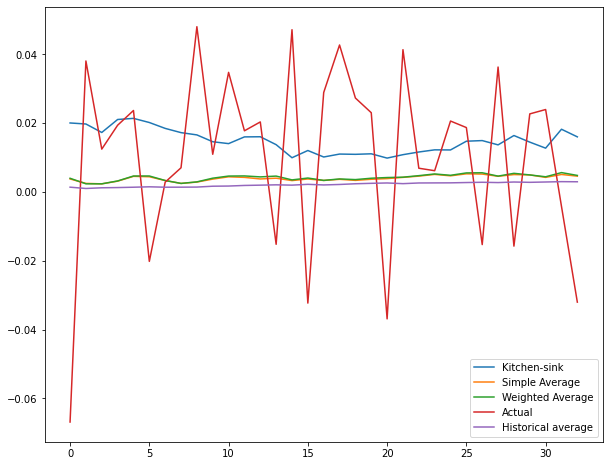

In [0]:
# Forecasts for NYSE
plt.figure(figsize=(10, 8))
plt.plot(nyse_results['forecasts']['combined_unrestricted'][:,0], label='Kitchen-sink')
plt.plot(nyse_results['forecasts']['combined_unrestricted'][:,1], label='Simple Average')
plt.plot(nyse_results['forecasts']['combined_unrestricted'][:,2], label='Weighted Average')
plt.plot(nyse_results['forecasts']['actual'], label='Actual')
plt.plot(nyse_results['forecasts']['ha'], label='Historical average')
plt.legend()
plt.show()

In [0]:
# Running the the models for NEPSE data from 1997
nepse_results = generate_results('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nepse_data.csv')

ERROR! Session/line number was not unique in database. History logging moved to new session 59
Shape of dataset:  (211, 8)
[[ 1.        ]
 [ 0.20221332]
 [-0.27166002]
 [-0.78386962]
 [ 0.59277286]]

R2OS for Unrestricted
------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,predictors,R2OS,p-value
0,svar,0.52,0.01
1,infl,-4.70,0.99
2,gov_bond_yields,1.06,0.14
3,treasury_yields,13.48,0.02
4,term_spreads,10.48,0.01
5,Kitchen sink,7.56,0.04
6,POOL-AVG,6.19,0.03
7,POOL-DMSFE,6.87,0.03



R2OS with restricted
------------------------------------------------------------


,predictors,R2OS,p-value
0,svar,0.00,NaN
1,infl,-4.61,0.99
2,gov_bond_yields,1.06,0.14
3,treasury_yields,13.48,0.02
4,term_spreads,10.48,0.02
5,Kitchen sink,7.56,0.04
6,POOL-AVG,6.19,0.03
7,POOL-DMSFE,6.87,0.03


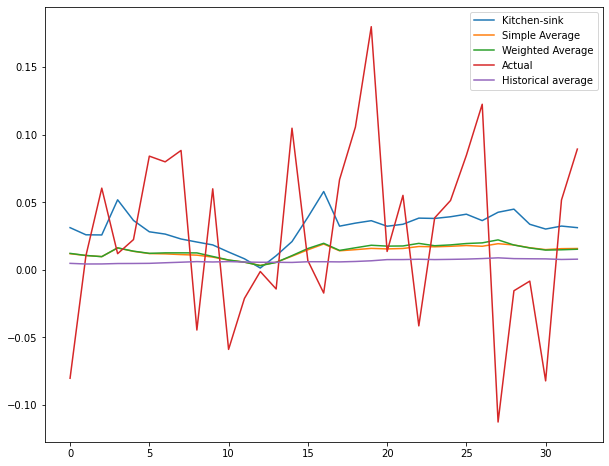

In [0]:
# Graphs for Forecasts from NEPSE
plt.figure(figsize=(10, 8))
plt.plot(nepse_results['forecasts']['combined_unrestricted'][:,0], label='Kitchen-sink')
plt.plot(nepse_results['forecasts']['combined_unrestricted'][:,1], label='Simple Average')
plt.plot(nepse_results['forecasts']['combined_unrestricted'][:,2], label='Weighted Average')
plt.plot(nepse_results['forecasts']['actual'], label='Actual')
plt.plot(nepse_results['forecasts']['ha'], label='Historical average')
plt.legend()
plt.show()